In [ ]:
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt
#PATHTarea = "../dataTarea2"
PATHTarea = "../data"

In [33]:
item_categories = pd.read_csv(f"{PATHTarea}/item_categories.csv")
items = pd.read_csv(f"{PATHTarea}/items.csv")
sales_train = pd.read_csv(f"{PATHTarea}/sales_train.csv")
sample_submission = pd.read_csv(f"{PATHTarea}/sample_submission.csv")
shops = pd.read_csv(f"{PATHTarea}/shops.csv")
test = pd.read_csv(f"{PATHTarea}/test.csv")

Chequemos los valores faltantes y cuantos hay de cada tipo

In [34]:
print("ITEM_CATEGORIES")
print(item_categories.info())
print("ITEMS")
print(items.info())
print("SALES_TRAIN")
print(sales_train.info())
# print("SAMPLE_SUBMISSION")
# print(sample_submission.info())
print("SHOPS")
print(shops.info())
print("TEST")
print(test.info())

ITEM_CATEGORIES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
ITEMS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
SALES_TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  in

In [62]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format ='%d.%m.%Y')
sales_train['month'] = sales_train['date'].dt.strftime('%m')
sales_train['month'] = sales_train['month'].astype("int")

eliminamos los outliers de sales_train

<Axes: >

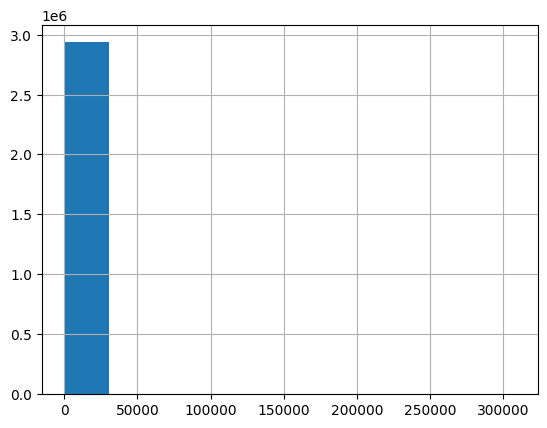

In [63]:
sales_train['item_price'].hist()

<Axes: >

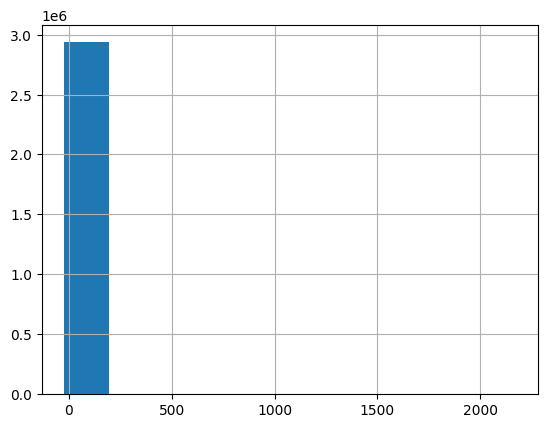

In [64]:
sales_train['item_cnt_day'].hist()

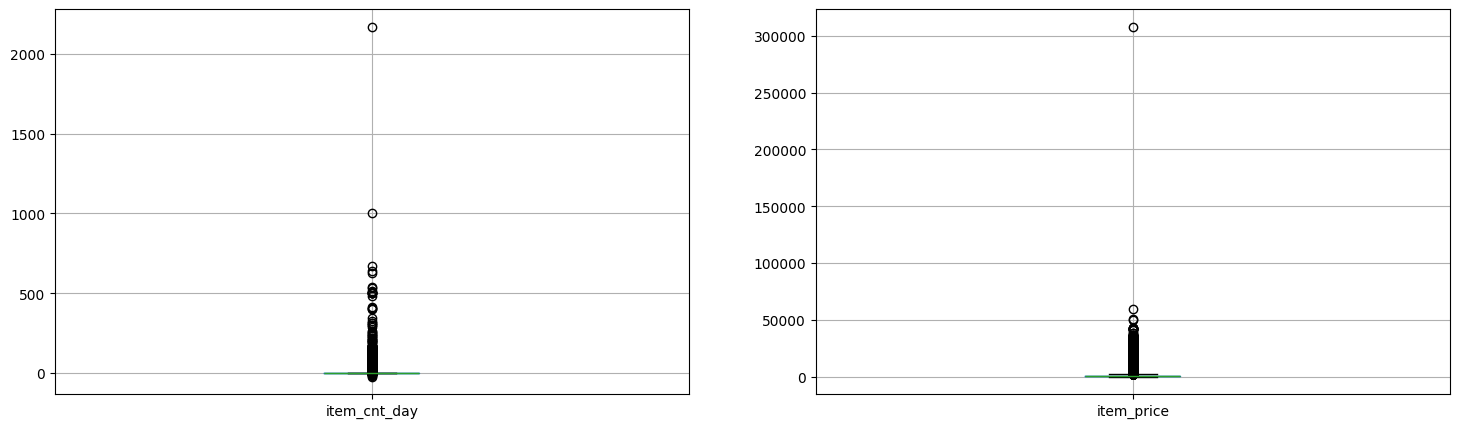

In [65]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sales_train[["item_cnt_day"]].boxplot()
plt.subplot(1, 2, 2)
sales_train[["item_price"]].boxplot()
plt.show()

In [66]:
def remove_outliers_iqr(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    return data[(data[col] >= lower) & (data[col] <= upper)]

In [67]:
non_negative_data = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_price'] > 0)]
fixed_item_cnt = remove_outliers_iqr(non_negative_data, "item_cnt_day")
clean_data = remove_outliers_iqr(fixed_item_cnt, "item_price")

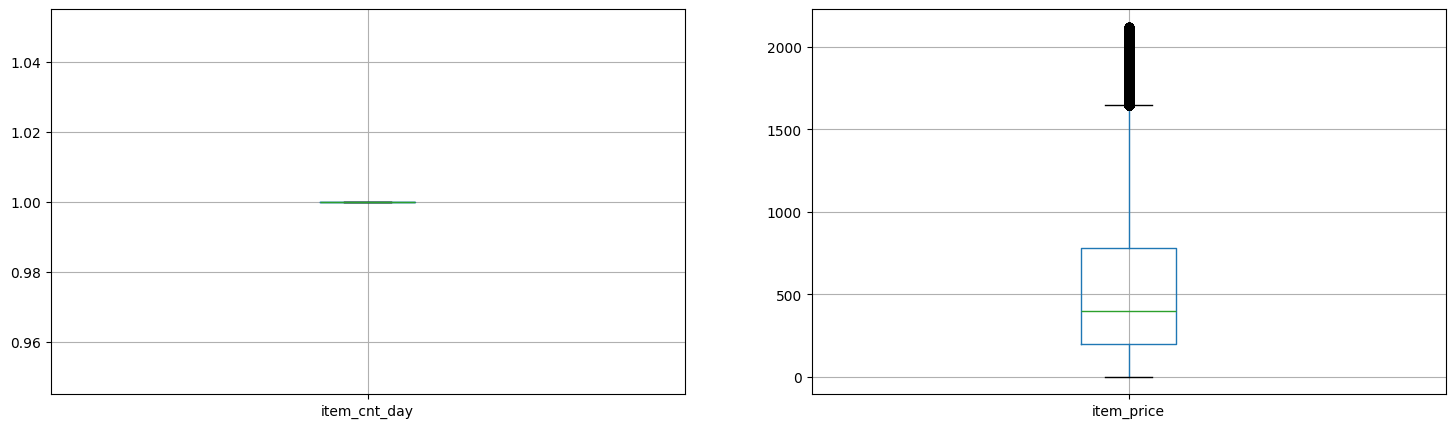

In [68]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
clean_data[["item_cnt_day"]].boxplot()
plt.subplot(1, 2, 2)
clean_data[["item_price"]].boxplot()
plt.show()

calculemos el porcentaje de datos que perdimos

In [69]:
clean_data.shape[0] / sales_train.shape[0]

0.8217728500341809

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'date_block_num'}>,
        <Axes: title={'center': 'shop_id'}>],
       [<Axes: title={'center': 'item_id'}>,
        <Axes: title={'center': 'item_price'}>,
        <Axes: title={'center': 'item_cnt_day'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >, <Axes: >]],
      dtype=object)

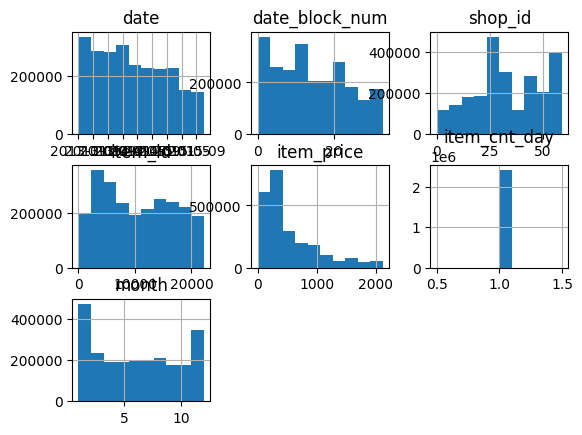

In [70]:
clean_data.hist()

exploremos correlaciones

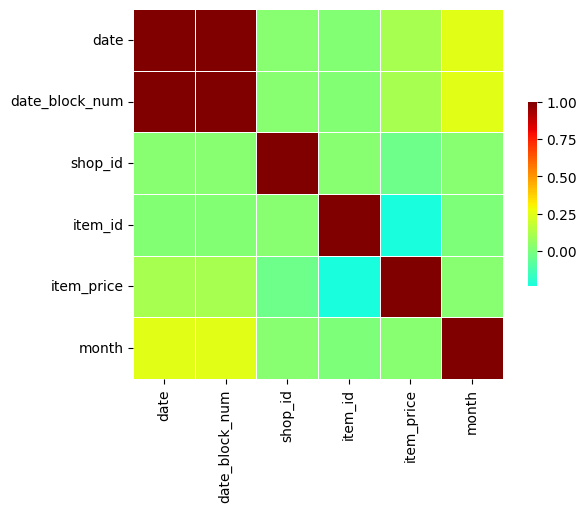

In [71]:
# como item_cnt_day es constante lo quitamos para la matriz de correlacion
templist = list(clean_data.columns)
templist.remove("item_cnt_day")


corrmat = clean_data[templist].corr()

sns.heatmap(corrmat, center=0, cmap='jet', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

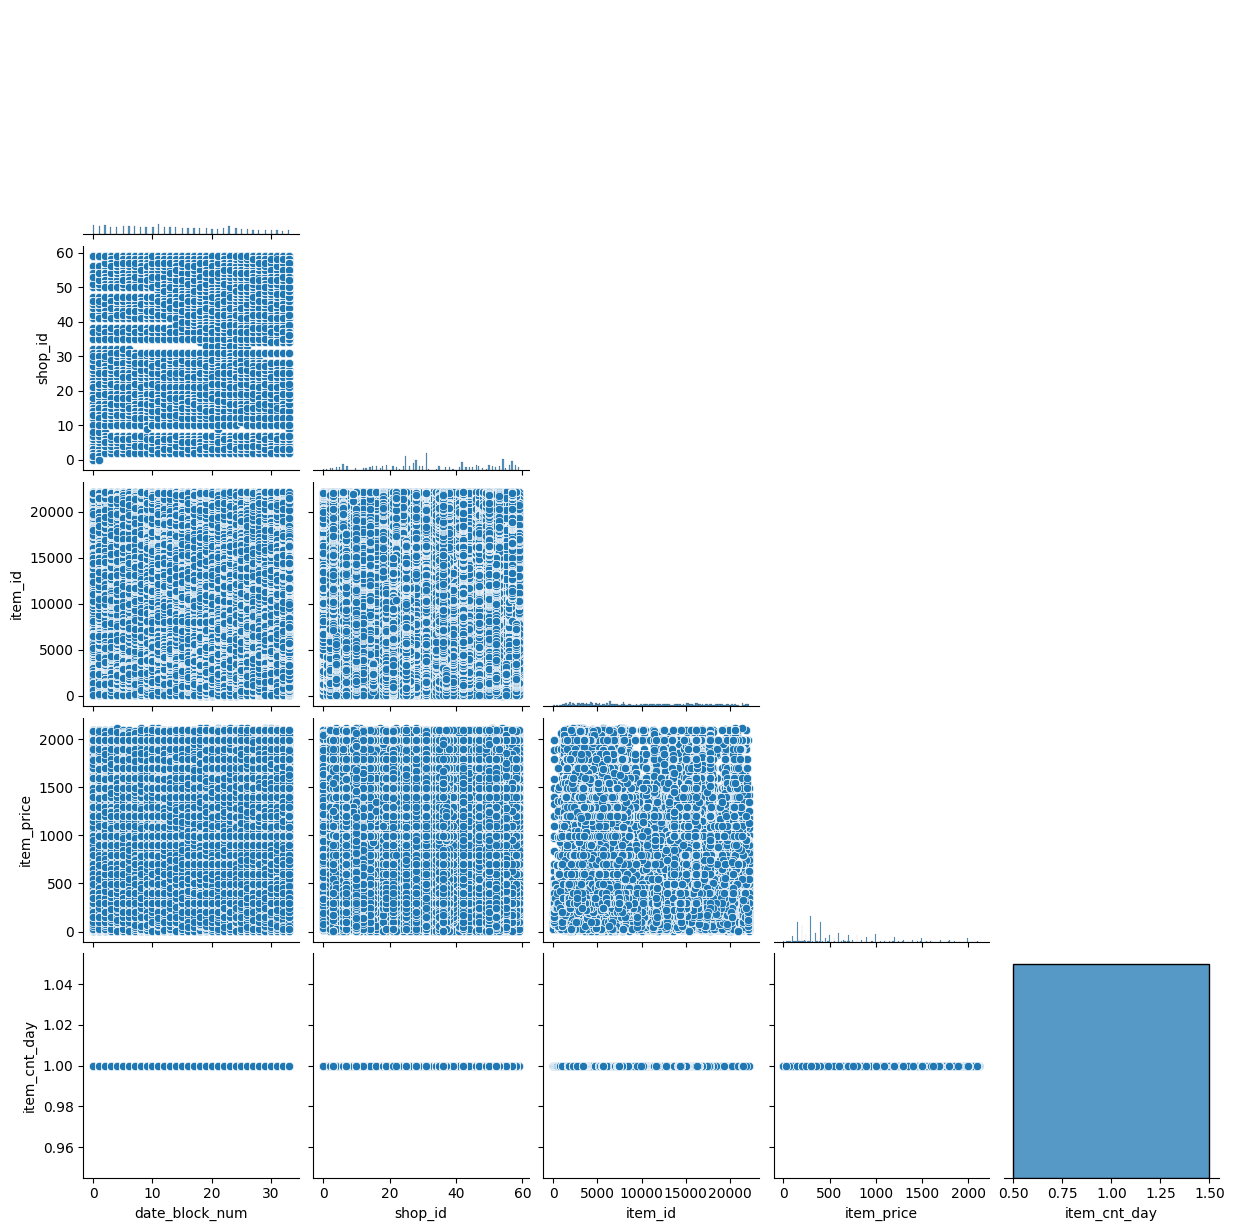

In [41]:
sns.pairplot(clean_data, corner=True)
plt.show()

In [72]:
## what if the items dont have consistent prices :O

price_variation = clean_data.groupby(["item_id"])["item_price"].nunique()

items_with_price_changes = price_variation[price_variation > 1]


if not items_with_price_changes.empty:
    print("Items with price changes detected:")
    print(items_with_price_changes)
else:
    print("All items have consistent prices.")

Items with price changes detected:
item_id
3         2
27       10
28       11
29        5
30       16
         ..
22162     9
22163     4
22164     9
22167     5
22168     2
Name: item_price, Length: 15031, dtype: int64


In [86]:
## later to be joined

items_info = clean_data[['item_id', 'item_price']]  # ID is not necessary here

# Selecting relevant data for aggregation
interested_data = clean_data[['date_block_num', 'month', 'shop_id', 'item_id', 'item_cnt_day']]

In [87]:
grouped_data = interested_data.groupby(['date_block_num', 'shop_id', 'item_id', 'month']).sum().reset_index()

In [88]:
grouped_data

,date_block_num,shop_id,item_id,month,item_cnt_day
0,0,0,32,1,2.0
1,0,0,33,1,3.0
2,0,0,35,1,1.0
3,0,0,43,1,1.0
4,0,0,51,1,2.0
...,...,...,...,...,...
1479286,33,59,22087,10,1.0
1479287,33,59,22088,10,2.0
1479288,33,59,22091,10,1.0
1479289,33,59,22100,10,1.0


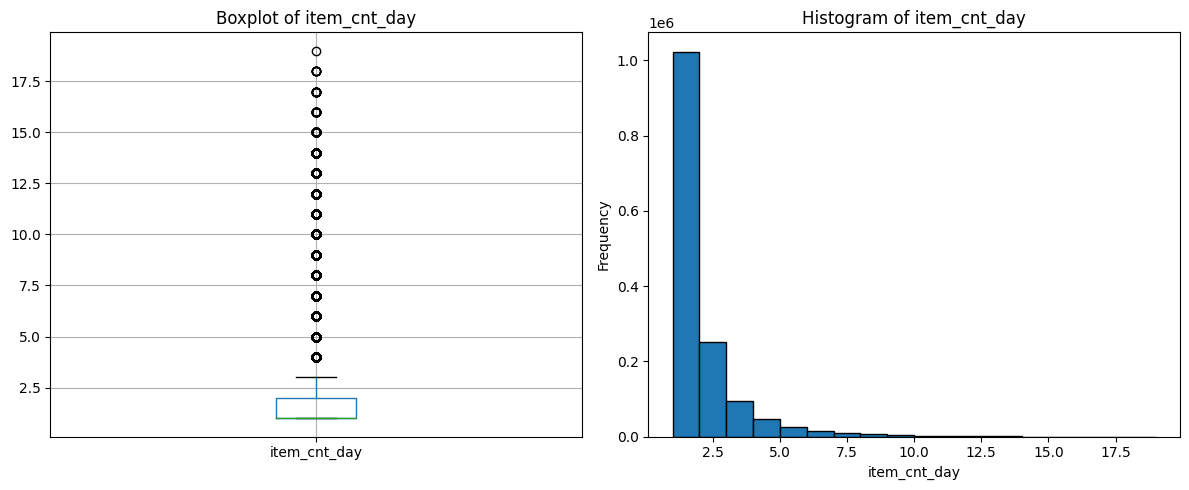

In [89]:
unique_bins = sorted(grouped_data['item_cnt_day'].unique())

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot on the left
grouped_data[['item_cnt_day']].boxplot(ax=axes[0])
axes[0].set_title("Boxplot of item_cnt_day")

# Histogram on the right with bins set to unique values
axes[1].hist(grouped_data['item_cnt_day'], bins=unique_bins, edgecolor='black', align='mid')
axes[1].set_title("Histogram of item_cnt_day")
axes[1].set_xlabel("item_cnt_day")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

In [90]:
grouped_data[grouped_data['item_cnt_day'] >= 3].shape[0] / grouped_data.shape[0]

0.1382966569795936

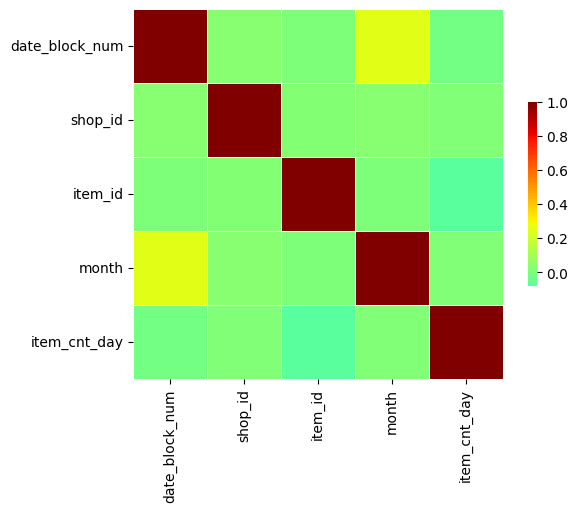

In [91]:
# como item_cnt_day es constante lo quitamos para la matriz de correlacion
corrmat = grouped_data.corr()

sns.heatmap(corrmat, center=0, cmap='jet', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [92]:
## fuck it lo vamos a tratar como un problema de multiclassification

grouped_data.to_csv("grouped_data.csv", index = False)
items_info.to_csv("items_info.csv", index = False) 

In [93]:
from tqdm import tqdm

grouped_data_parts = pd.read_csv("grouped_data.csv", chunksize = 10000)
items_info_parts = pd.read_csv("items_info.csv", chunksize=10000)

df_list = []
for chunk_item in tqdm(items_info_parts): 
    for chunk_grouped in grouped_data_parts:
        df_list.append(pd.merge(chunk_item, chunk_grouped, how = "inner", on = "item_id"))
        

242it [00:01, 219.56it/s]


In [94]:
joined_data = pd.concat(df_list)

data persistance

In [95]:
joined_data.to_csv("joined_data.csv", index = False)

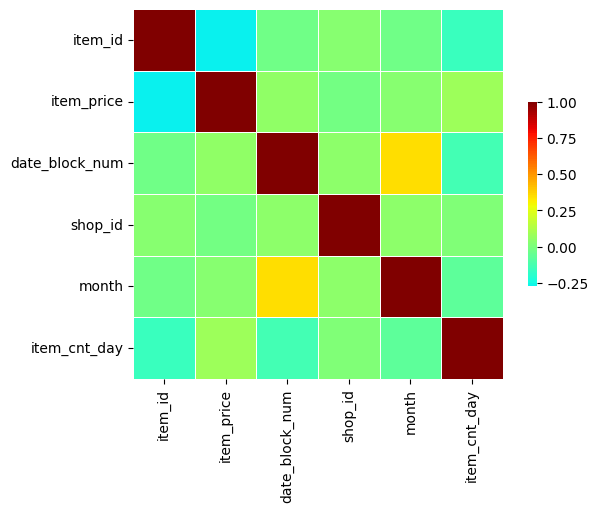

In [96]:
corrmat = joined_data.corr()

sns.heatmap(corrmat, center=0, cmap='jet', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()